In [1]:
%pylab inline
import seaborn as sns
import numpy as np
import pandas as pd
import cPickle as pickle
from irm import cvpipelineutil
import sklearn.neighbors
import scipy.sparse
import irm
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [2]:
neurons_data = pickle.load(open("../data/mushroombody.neurondf.pickle", 'r'))
synapse_data = pickle.load(open("../data/mushroombody.synapsesdf.pickle", 'r'))
basicmat_data = pickle.load(open("../data/mushroombody.cleandata.pickle", 'r'))
kc_mbon_rosettes = pickle.load(open("../data/mushroombody.KC-MBON.rosette.df.pickle", 'r'))
rosette_df = kc_mbon_rosettes['rosette_df']
tbar_df = synapse_data['tbar_df']
connections_df = synapse_data['connections_df']
neurons_df = neurons_data['neurondf']


In [8]:
d = pickle.load(open("../data/mushroombody.KC-rosette-KC.mats.pickle", 'r'))

In [12]:
a = d['all_results'][(20, True)]
kc_kc_mats = a['kc_kc_mats']
kc_rosette_kc_mats = a['kc_rosette_kc_mats']
pre_ids_names_sorted = d['pre_ids_names_sorted']
pre_ids_to_pos = d['pre_ids_to_pos']
pre_ids
sort_order = d['sort_order']
KCN = len(sort_order)

In [14]:
for mbon_name in kc_rosette_kc_mats.keys():

    fig = pylab.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    rosette_mat = kc_rosette_kc_mats[mbon_name]
    conn_mat = rosette_mat[:, :, 2:].sum(axis=2)
    
    
    kc_kc_mat = kc_kc_mats[mbon_name]
    conn_rand = conn_mat[sort_order]
    conn_rand = conn_rand[:, sort_order]
    
    kc_kc_sorted = kc_kc_mat[sort_order]
    kc_kc_sorted = kc_kc_sorted[:, sort_order]
    
    
    a = np.argwhere(conn_rand)
    print len(a)
    counts = np.array([conn_rand[i, j] for i, j in a])
    ax.scatter(a[:, 0], a[:, 1], edgecolor='none', c='r',
               s=10*counts**2, alpha=0.1)
    ax.set_xlim(0, KCN)
    ax.set_ylim(KCN, 0)
    
    im = np.ones((kc_kc_sorted.shape[0], kc_kc_sorted.shape[1], 4))
    im[:, :, 2] = 1-kc_kc_sorted
    im[:, :, 0] = 1-kc_kc_sorted
    im[:, :, 1] = 1-kc_kc_sorted
    im[:, :, 3] = kc_kc_sorted * 0.05
    ax.imshow(im)
    ticks = np.arange(0, KCN, 20)
    ax.set_yticks(ticks)
    ax.set_yticklabels(pre_ids_names_sorted[ticks])
    ax.set_xticks(ticks)
    ax.set_xticklabels(pre_ids_names_sorted[ticks], rotation=90)
    #ax.set_yticks([])
    ax.set_title(mbon_name)
    ax.grid(False)
    ax.set_xlabel("kenyon cell ID")
    ax.set_ylabel("kenyon cell ID")
    fig.savefig("kc-rosette-kc %s.png" % mbon_name, dpi=300)
    break

18500


In [28]:
pylab.imshow(conn_mat > 0)

In [29]:
# inference? 

from irm import cvpipelineutil
import sklearn.neighbors
import scipy.sparse
import irm

conmat = (conn_mat > 0).astype(np.uint8)

model_name = "BetaBernoulliNonConj"
init, data = irm.irmio.default_graph_init(conmat, model_name)
init['domains']['d1']['assignment'] = np.random.permutation(len(conmat)) % 50

HPS = {'alpha' : 1.0, 'beta' : 1.0}

init['relations']['R1']['hps'] = HPS
ITERS = 40
slow_anneal = irm.runner.default_kernel_anneal(iterations=int(0.7*ITERS))

kc ={'ITERS' : ITERS, 
    'kernels' : slow_anneal}

s = cvpipelineutil.run_exp_pure(data, init, 'anneal_slow_10', 0, kc)


Creating threadpool with 8 cores
FIXED_K= False
Running with relation_class= <class 'irm.pyirmutil.ParRelation'>
This model fixed_k=  False
Annealing at temp= 32.0
kernels: nonconj_gibbs 5.38 sec
kernels: slice_params 0.21 sec
kernels: domain_hp_grid 0.07 sec
kernels: relation_hp_grid 0.10 sec
kernels: anneal 5.76 sec
Iter 1
Annealing at temp= 28.1451574687
kernels: nonconj_gibbs 3.69 sec
kernels: slice_params 0.12 sec
kernels: domain_hp_grid 0.07 sec
kernels: relation_hp_grid 0.09 sec
kernels: anneal 3.98 sec
Iter 2
Annealing at temp= 24.7546840292
kernels: nonconj_gibbs 2.49 sec
kernels: slice_params 0.16 sec
kernels: domain_hp_grid 0.07 sec
kernels: relation_hp_grid 0.10 sec
kernels: anneal 2.81 sec
Iter 3
Annealing at temp= 21.7726400028
kernels: nonconj_gibbs 5.12 sec
kernels: slice_params 0.16 sec
kernels: domain_hp_grid 0.07 sec
kernels: relation_hp_grid 0.09 sec
kernels: anneal 5.43 sec
Iter 4
Annealing at temp= 19.1498244183
kernels: nonconj_gibbs 5.18 sec
kernels: slice_param

In [30]:
res = s['res']
scores, state, times, _ = res

([], <a list of 0 Text yticklabel objects>)

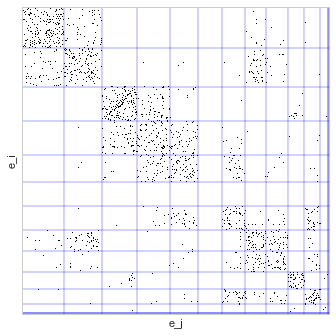

In [31]:
a = irm.util.canonicalize_assignment(state['domains']['d1']['assignment'])
ca = np.argsort(a).flatten()

conmat_sorted = conmat[ca]
conmat_sorted = conmat_sorted[:, ca]
pylab.imshow(conmat_sorted > 0, interpolation='nearest', cmap=pylab.cm.Greys)
pylab.grid(False)
pylab.ylabel('e_i')
pylab.xlabel('e_j')

pos = np.argwhere(np.diff(a[ca]))
for p in pos:
    pylab.axhline(p, c='b', alpha=0.2)
    pylab.axvline(p, c='b', alpha=0.2)

pylab.xticks([])
pylab.yticks([])
#pylab.title("e_i tries to talk to e_j")
#pylab.savefig("dist.distrecover.png")